In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense
from tensorflow.keras import Sequential
from sklearn.metrics import r2_score
import pandas as pd
import keras
from keras import backend as K
print(tf.__version__)

2.7.0


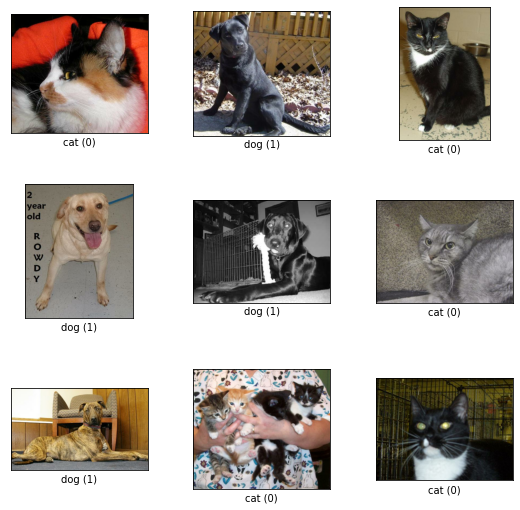

In [443]:
(ds_train_mnist, ds_test_mnist), ds_info = tfds.load(
    name = 'cats_vs_dogs',
    split=['train[:20%]', 'train[20%:30%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)
fig = tfds.show_examples(ds_train_mnist, ds_info)

In [444]:
label_names = ds_info.features['label'].names

In [493]:
def augment_data(images, labels):
    images = tf.image.resize(images,(128,128))
    images = tf.image.random_flip_left_right(images)
    images = tf.image.rot90(images)
    images = tf.image.random_brightness(images, 0.2)
    images = tf.image.random_contrast(images, 0.5, 2.0)
    images = tf.image.random_saturation(images, 0.75, 1.25)
    return tf.cast(images, tf.float32) / 255., labels

def data_load(data_ds,augmented=augment_data,shuffle_=True ,batch_=5):
    data_ds = data_ds.map(
        augmented, num_parallel_calls=tf.data.AUTOTUNE)
    data_ds = data_ds.cache()
    if shuffle_:
        data_ds = data_ds.shuffle(len(data_ds))
    data_ds = data_ds.batch(batch_)
    data_ds = data_ds.prefetch(tf.data.AUTOTUNE)
    return data_ds

In [495]:
data_train = data_load(ds_train_mnist)
data_test = data_load(ds_test_mnist,shuffle_=False)
for ds,lb in data_train.take(1):
    shaped=list(ds.shape)


In [448]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=shaped[1:]),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(2,activation='softmax')
])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 49152)             0         
                                                                 
 dense_37 (Dense)            (None, 64)                3145792   
                                                                 
 dense_38 (Dense)            (None, 2)                 130       
                                                                 
Total params: 3,145,922
Trainable params: 3,145,922
Non-trainable params: 0
_________________________________________________________________


In [449]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [450]:
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min' ,factor=0.4,
                              patience=5, min_lr=1e-7,verbose=1)
directory_files='carpeta_resultados_clase/'
def scheduler(epoch, lr):
      if epoch%10 != 0:
        return lr
      else:
        return lr * tf.math.exp(-0.1)
callback_Scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=directory_files+'model.{epoch:02d}-{val_loss:.2f}.h5',
                                               verbose=1,
                                               save_best_only=True)
tensorboard =tf.keras.callbacks.TensorBoard(log_dir=directory_files+'logs', histogram_freq=1),

callbacks=[tensorboard, checkpoint,early_callback,callback_Scheduler]


history= model.fit(
    data_train,
    epochs=6,
    validation_data=data_test,
    callbacks=callbacks,
    verbose=1)


Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.00090483745, shape=(), dtype=float32).
Epoch 1/6
929/931 [============================>.] - ETA: 0s - loss: 1.3986 - accuracy: 0.5393
Epoch 00001: val_loss improved from inf to 0.68566, saving model to carpeta_resultados_clase/model.01-0.69.h5
931/931 [==============================] - 15s 14ms/step - loss: 1.3977 - accuracy: 0.5389 - val_loss: 0.6857 - val_accuracy: 0.4963 - lr: 9.0484e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 2/6
929/931 [============================>.] - ETA: 0s - loss: 0.6801 - accuracy: 0.5640
Epoch 00002: val_loss improved from 0.68566 to 0.68083, saving model to carpeta_resultados_clase/model.02-0.68.h5
931/931 [==============================] - 13s 14ms/step - loss: 0.6801 - accuracy: 0.5638 - val_loss: 0.6808 - val_accuracy: 0.5608 - lr: 9.0484e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 

In [451]:
model.evaluate(data_test)

466/466 [==============================] - 2s 3ms/step - loss: 0.6675 - accuracy: 0.5930


[0.6674802303314209, 0.5930382609367371]

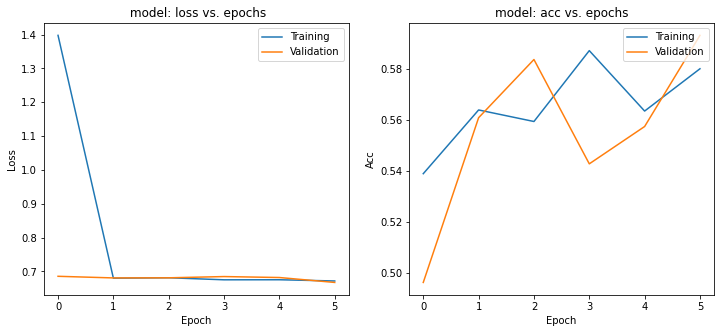

In [452]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model: acc vs. epochs')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

In [453]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

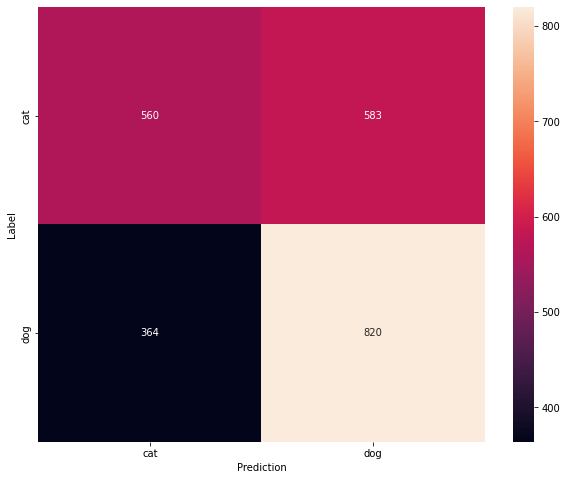

In [454]:
pred=[]
lab=[]
for ds, lb in data_test:
    pred.append(tf.math.argmax(model.predict(ds),axis=1))
    lab.append(lb)
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(lab),
    np.concatenate(pred),
    num_classes=len(label_names))
show_confusion_matrix(confusion_mtx, label_names)

In [455]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout,Dense
modelcnn = Sequential()
modelcnn.add(Conv2D(16,activation='relu' , strides=(1, 1),kernel_size=(5,5),padding='same', input_shape=shaped[1:]))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Conv2D(32,activation='relu',  strides=(1, 1),kernel_size=(3,3),padding='same'))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Conv2D(32,activation='relu',  strides=(1, 1),kernel_size=(3,3),padding='same'))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the 2D arrays for fully connected layers
modelcnn.add(Flatten()) 
#modelcnn.add(tf.keras.layers.GlobalAveragePooling2D())
modelcnn.add(Dense(128, activation=tf.nn.relu))
modelcnn.add(Dropout(0.2))
modelcnn.add(Dense(2,activation=tf.nn.softmax))
modelcnn.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 128, 128, 16)      1216      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 16, 16, 32)     

In [456]:
modelcnn.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [457]:
directory_files='carpeta_resultados_clasecnn/'

In [458]:

early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min' ,factor=0.4,
                              patience=5, min_lr=1e-7,verbose=1)

def scheduler(epoch, lr):
      if epoch%10 != 0:
        return lr
      else:
        return lr * tf.math.exp(-0.1)
callback_Scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=directory_files+'model.{epoch:02d}-{val_loss:.2f}.h5',
                                               verbose=1,
                                               save_best_only=True)
tensorboard =tf.keras.callbacks.TensorBoard(log_dir=directory_files+'logs', histogram_freq=1),

callbacks=[tensorboard, checkpoint,early_callback,callback_Scheduler]


historycnn= modelcnn.fit(
    data_train,
    epochs=6,
    validation_data=data_test,
    callbacks=callbacks,
    verbose=1)


Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.00090483745, shape=(), dtype=float32).
Epoch 1/6
931/931 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.5406
Epoch 00001: val_loss improved from inf to 0.68112, saving model to carpeta_resultados_clasecnn/model.01-0.68.h5
931/931 [==============================] - 50s 53ms/step - loss: 0.6940 - accuracy: 0.5406 - val_loss: 0.6811 - val_accuracy: 0.5917 - lr: 9.0484e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 2/6
931/931 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.5929
Epoch 00002: val_loss improved from 0.68112 to 0.62487, saving model to carpeta_resultados_clasecnn/model.02-0.62.h5
931/931 [==============================] - 51s 54ms/step - loss: 0.6691 - accuracy: 0.5929 - val_loss: 0.6249 - val_accuracy: 0.6493 - lr: 9.0484e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009048374486155808.


In [459]:
modelcnn.evaluate(data_test)

466/466 [==============================] - 6s 13ms/step - loss: 0.6871 - accuracy: 0.6962


[0.6870744228363037, 0.6961753368377686]

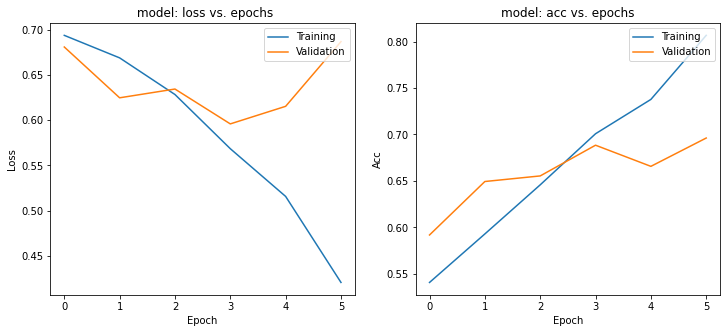

In [460]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(historycnn.history['loss'])
plt.plot(historycnn.history['val_loss'])
plt.title(' model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(historycnn.history['accuracy'])
plt.plot(historycnn.history['val_accuracy'])
plt.title('model: acc vs. epochs')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

(<matplotlib.image.AxesImage at 0x7f737ccf2f10>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

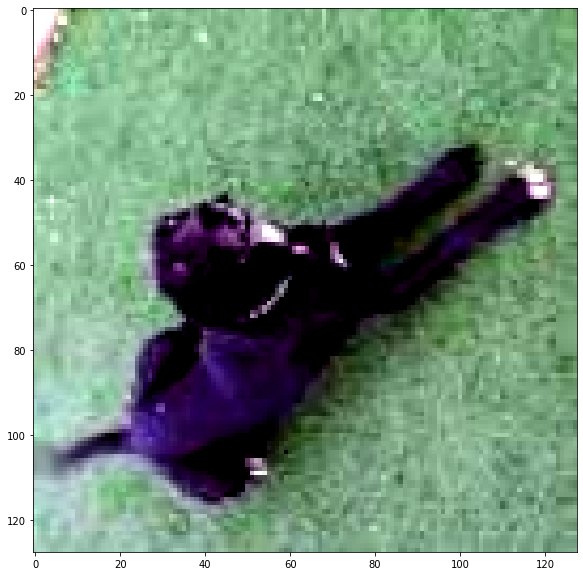

In [503]:
plt.imshow(ds[0]),lb[0]

In [499]:
successive_outputs = [layer.output for layer in modelcnn.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = modelcnn.input, outputs = successive_outputs)



In [500]:
successive_feature_maps = visualization_model.predict(tf.expand_dims(ds[0],axis=0))

In [501]:
layer_names = [layer.name for layer in modelcnn.layers]

(1, 64, 64, 16)
(1, 64, 64, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 16, 16, 32)
(1, 8192)
(1, 128)
(1, 128)
(1, 2)


<ipython-input-502-885cb4c0fd52>:20: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


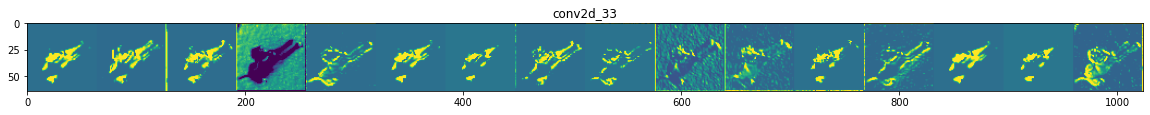

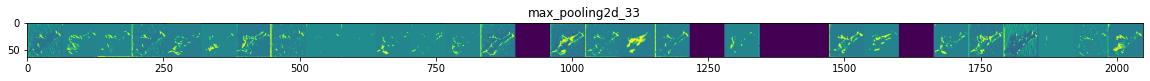

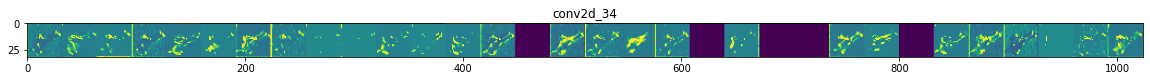

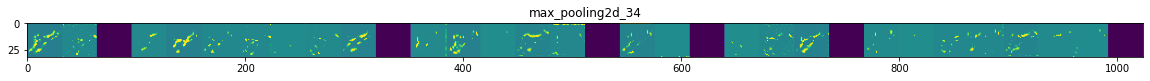

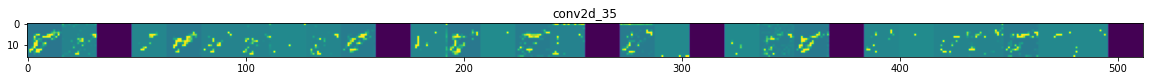

In [502]:
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [2]:
df = pd.read_csv('Documents/coursera_TF_1/Sunspots.csv', index_col=0)
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


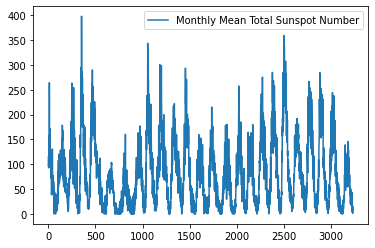

In [3]:
df.plot()
plt.show()

In [5]:
time_index = np.array(df['Date'])
data = np.array(df['Monthly Mean Total Sunspot Number'])
print(time_index.shape)
print(data.shape)

(3235,)
(3235,)


In [42]:
##Hiperparametros
SPLIT_TEST_TRAIN = 0.8
WINDOW_SIZE = 60
BATCH_SIZE = 32
SHUFFLE_BUFFER = 1000

In [43]:
split_index = int(SPLIT_TEST_TRAIN * data.shape[0])
print(split_index)

2588


In [44]:
train_data = data[:split_index]
train_time = time_index[:split_index]

test_data = data[split_index:]
test_time = time_index[split_index:]

In [45]:
def ts_data_timeseries(data, window_size, batch_size):
  
  ds = tf.data.Dataset.from_tensor_slices(data)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.map(lambda window: (window[:-1], window[-1]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds



In [46]:
train_dataset = ts_data_timeseries(train_data, WINDOW_SIZE, BATCH_SIZE)
test_dataset = ts_data_timeseries(test_data, WINDOW_SIZE, BATCH_SIZE)

In [39]:
 for ds in train_dataset.take(1):
        print(ds)

(<tf.Tensor: shape=(4, 6), dtype=float64, numpy=
array([[ 96.7, 104.3, 116.7,  92.8, 141.7, 139.2],
       [104.3, 116.7,  92.8, 141.7, 139.2, 158. ],
       [116.7,  92.8, 141.7, 139.2, 158. , 110.5],
       [ 92.8, 141.7, 139.2, 158. , 110.5, 126.5]])>, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([158. , 110.5, 126.5, 125.8])>)


In [41]:
df.head(2)

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3


In [52]:
model_flat = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[WINDOW_SIZE], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
model_flat.summary()

model_flat.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
history_flat=model_flat.fit(train_dataset, epochs=3,validation_data = test_dataset)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                1220      
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
79/79 [==============================] - 1s 9ms/step - loss: 2116.1223 - val_loss: 1803.5441
Epoch 2/3
79/79 [==============================] - 1s 7ms/step - loss: 1481.6593 - val_loss: 1350.8455
Epoch 3/3
79/79 [==============================] - 1s 7ms/step - loss: 1278.2495 - val_loss: 1160.5979


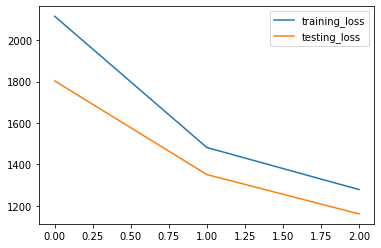

In [53]:
plt.plot( history_flat.history["loss"], label = "training_loss")
plt.plot( history_flat.history["val_loss"], label = "testing_loss")
plt.legend()

In [83]:
def plots_pred(model, data, test_data, conv=True):
    forecast=[]
    for time in range(split_index-WINDOW_SIZE,len(data) - WINDOW_SIZE):
      forecast.append(model.predict(data[time:time + WINDOW_SIZE][np.newaxis]))

    forecast = forecast[:]
    results = np.array(forecast)[:, 0, 0]
    if conv:
        results= np.squeeze(results)

    error_test = tf.keras.metrics.mean_absolute_error(test_data, results).numpy()
    plt.figure(figsize=(15, 6))

    plt.plot(list(range(split_index,len(data))), test_data, label = 'Test Data')
    plt.plot(list(range(split_index,len(data))), results, label = 'Predictions')
    plt.fill_between(range(split_index,len(data)), results - error, results + error, alpha = 0.3, color = 'grey',label=r'error 1-$\sigma$')
    plt.legend()
    plt.show()

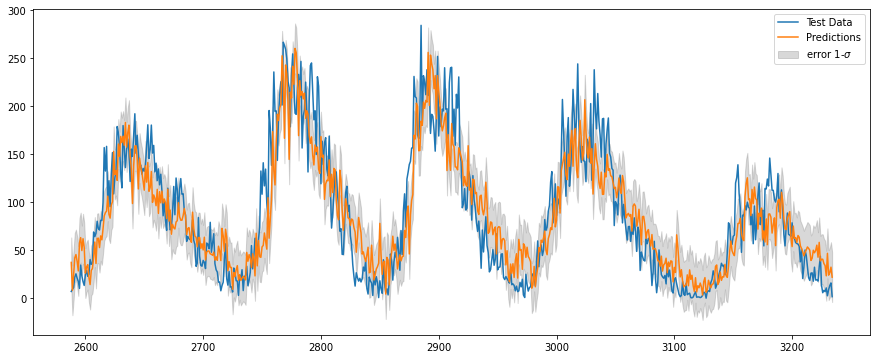

In [82]:
 plots_pred(model_flat, data, test_data, conv=False)

In [86]:
modelcnn = keras.models.Sequential()
modelcnn.add(keras.layers.InputLayer(input_shape=[WINDOW_SIZE]))
modelcnn.add(keras.layers.Lambda(
       lambda inputs: tf.expand_dims(inputs,axis=0)))
for _ in range(3):
    modelcnn.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu"))
modelcnn.add(keras.layers.Conv1D(filters=1, kernel_size=1))
modelcnn.summary()
modelcnn.compile(loss="mse", optimizer="adam", metrics=['mse'])
historycnn = modelcnn.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (1, None, 60)             0         
                                                                 
 conv1d_18 (Conv1D)          (1, None, 20)             2420      
                                                                 
 conv1d_19 (Conv1D)          (1, None, 20)             820       
                                                                 
 conv1d_20 (Conv1D)          (1, None, 20)             820       
                                                                 
 conv1d_21 (Conv1D)          (1, None, 1)              21        
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
79/79 [==============================] - 

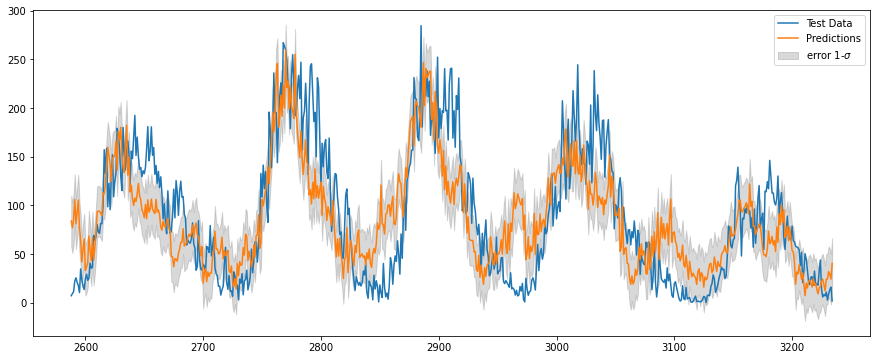

In [87]:
 plots_pred(modelcnn, data, test_data)

In [88]:
modelwavelet = keras.models.Sequential()
modelwavelet.add(keras.layers.InputLayer(input_shape=[WINDOW_SIZE]))
modelwavelet.add(keras.layers.Lambda(
       lambda inputs: tf.expand_dims(inputs,axis=0)))
for rate in (1, 2, 4, 8) * 2:
    modelwavelet.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
modelwavelet.add(keras.layers.Conv1D(filters=1, kernel_size=1))
modelwavelet.compile(loss="mse", optimizer="adam", metrics=['mse'])
history = modelwavelet.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
79/79 [==============================] - 2s 13ms/step - loss: 5723.2324 - mse: 5723.2324 - val_loss: 3278.9290 - val_mse: 3278.9290
Epoch 2/10
79/79 [==============================] - 1s 7ms/step - loss: 2591.4028 - mse: 2591.4028 - val_loss: 2102.0745 - val_mse: 2102.0745
Epoch 3/10
79/79 [==============================] - 1s 7ms/step - loss: 2175.7043 - mse: 2175.7043 - val_loss: 1884.7734 - val_mse: 1884.7734
Epoch 4/10
79/79 [==============================] - 1s 7ms/step - loss: 1990.1792 - mse: 1990.1792 - val_loss: 1814.3616 - val_mse: 1814.3616
Epoch 5/10
79/79 [==============================] - 1s 7ms/step - loss: 1882.6375 - mse: 1882.6375 - val_loss: 1744.2955 - val_mse: 1744.2955
Epoch 6/10
79/79 [==============================] - 1s 7ms/step - loss: 1856.1971 - mse: 1856.1971 - val_loss: 1681.2737 - val_mse: 1681.2737
Epoch 7/10
79/79 [==============================] - 1s 7ms/step - loss: 1804.1754 - mse: 1804.1754 - val_loss: 1607.3081 - val_mse: 1607.3081
Epoch

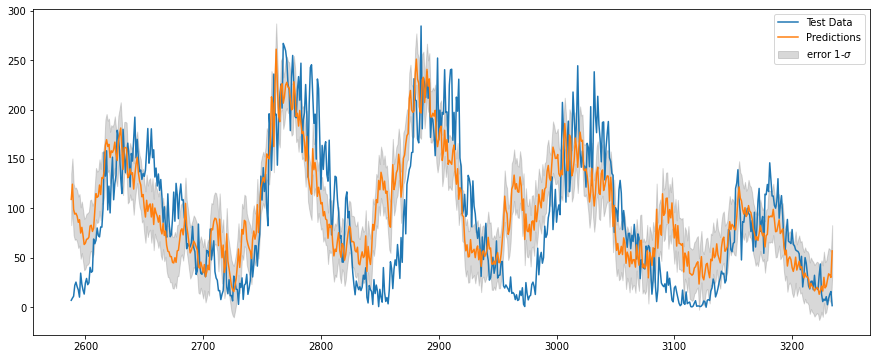

In [89]:
 plots_pred(modelwavelet, data, test_data)